# Time Series analysis


I analyze the stocks data for time series analysis. 
Techniques like MA, AR, and ARIMA models will be used. 

In [118]:
import yfinance as yfin
import numpy as np 
import pandas as pd 
import pandas_datareader.data as pdr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats


yfin.pdr_override()

# List of stock symbols
ticker = 'MSFT'

# Set the date range for the historical data
start_date = '2019-1-1'
end_date = '2021-1-1'
# Download historical stock data for each stock

stock = pdr.get_data_yahoo(ticker, start_date, end_date,interval='1d').Close



[*********************100%%**********************]  1 of 1 completed


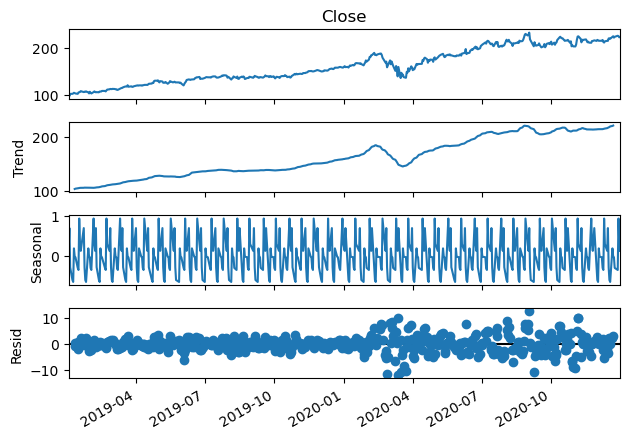

In [94]:
# Plot  the components of a time series by
# seasonal_decompose function from statsmodels
import matplotlib.pyplot as plt

seasonal_decompose(stock, period=12).plot()
plt.gcf().autofmt_xdate()
plt.show()

## ACF and PCF

Auto-correlation functions (ACF) show the correlation between the same series with different lags. With h being the lag:

$ρ(h) = \frac{Cov(X_t , X_{t−h} )}{Var(X_t )}$

The coefficients help in deciding the q in MA(q) models.

Partial ACF (PACF) gives information on correlation between current value of a time series
and its lagged values controlling for the other correlations.

$ρ(h) = \frac{Cov(X_t ,X_{t−h} |X_{t−1} ,X_{t−2} ...X_{t−h−1})}{
\sqrt{Var(X_t |X_{t−1} ,X_{t−2} ,...,X_{t−h−1} )Var(X_{t−h} |X_{t−1} ,X_{t−2} ,...,X_{t−h−1} )}}$

The coefficients help in deciding the p in AR(p) models.


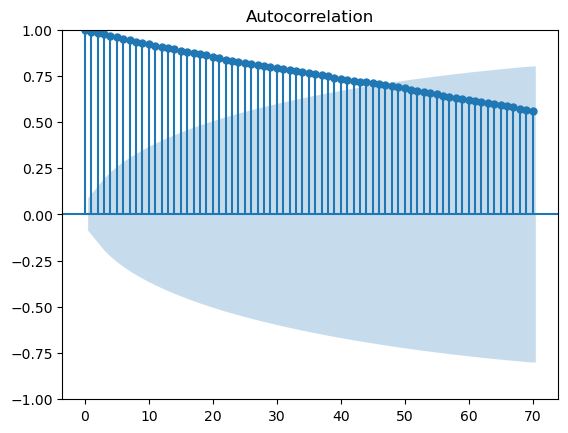

In [95]:
sm.graphics.tsa.plot_acf(stock,lags=70)
plt.show()

It shows that  there is strong dependence between the current value and lagged values of
stock data as the coefficients of autocorrelation decay slowly.

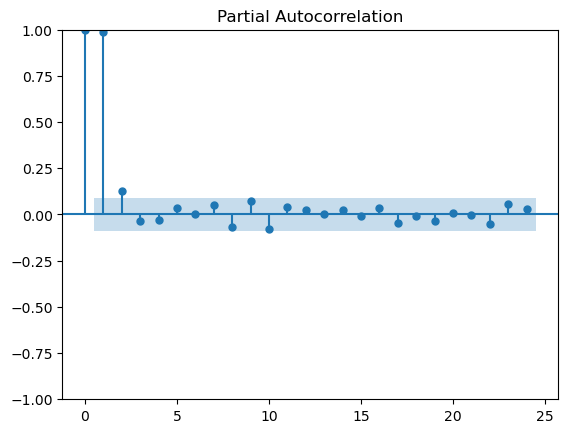

In [96]:
sm.graphics.tsa.plot_pacf(stock, lags=24)
plt.show()

Lines above the confidence intervals are considered significant. We see the model with lag of 2 coefficient is enough to model the variations.

## Time Series modeling

### Moving Average (MA)

Moving average can be considered as smoothing model as it tends to take into account the lag
values of residual.

For $\alpha \ne 0$, MA(q) can be written as:

$X_t = \epsilon_t + \alpha_1 \epsilon_{t−1} + \alpha_2 \epsilon_{t−2} ... + \alpha_q \epsilon_{t−q}$


In [179]:

# choose data over 2 years
start_date = '2019-1-1'
end_date = '2021-1-1'

# get the data with 1d interval 
stocks = pdr.get_data_yahoo(ticker, start_date, end_date,interval='1d').Close
stocks.dropna(inplace=True)
returns = stocks.pct_change()
returns.dropna(inplace=True)
stat_test = adfuller(returns.dropna())[0:2]
print(f"The test statistic and p-value of ADF test are {stat_test}")
if stat_test[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is not stationary")

# split the data into train and test
split = int(len(returns.values) * 0.90)

price_train = stocks.iloc[:split+1]
price_test = stocks.iloc[split:]
return_train = returns.iloc[:split]
return_test = returns.iloc[split:]
print(return_test.shape,return_train.shape,price_test.shape,price_train.shape,stock.shape)


[*********************100%%**********************]  1 of 1 completed
The test statistic and p-value of ADF test are (-7.212097179922102, 2.2211435488651752e-10)
The data is stationary
(51,) (453,) (52,) (454,) (505,)


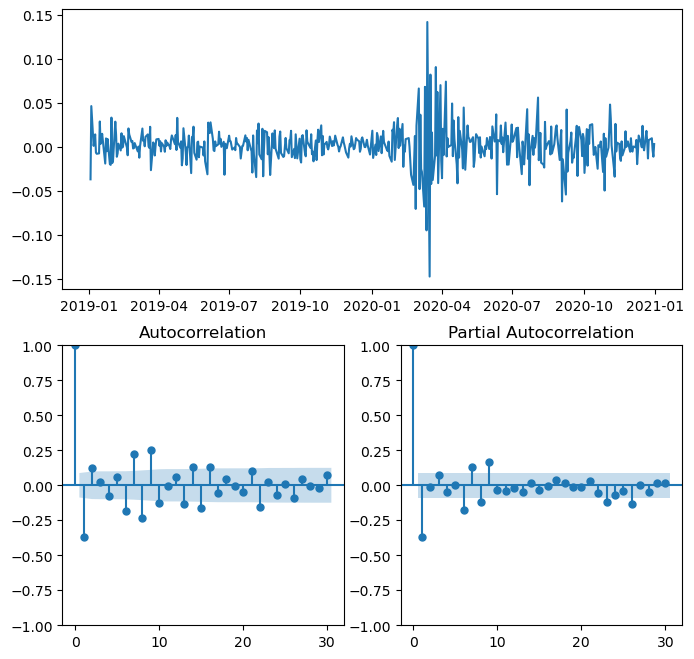

In [180]:

def ts_plots(data,lags):
    mosaic = """
    AA
    BC
    """
    fig = plt.figure(figsize=(8,8))
    ax = fig.subplot_mosaic(mosaic)
    ax['A'].plot(data)
    sm.graphics.tsa.plot_acf(returns.dropna(),ax=ax['B'],lags=lags)
    sm.graphics.tsa.plot_pacf(returns.dropna(),ax=ax['C'],lags=lags)
    
    fig.subplots_adjust()

ts_plots(returns,lags=30)
plt.show()

Peaks at 1 in ACF, we choose them order for MA i.e. MA(1) Model

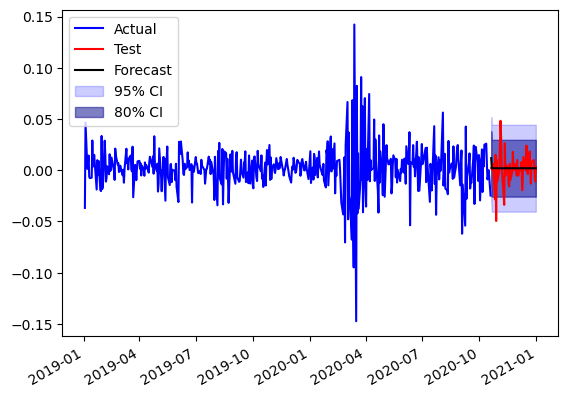

In [218]:
from statsmodels.tsa.arima.model import ARIMA

modelMA = ARIMA(return_train, order=(0, 0, 1)).fit()

forecast = modelMA.get_forecast(steps=len(return_test))

conf_int95 = forecast.conf_int(alpha=0.05)
conf_int80 = forecast.conf_int(alpha=0.2)


fig,ax = plt.subplots()
ax.plot(return_train.index,return_train.values,color='b',label='Actual')
ax.plot(return_test.index,return_test.values,color='r',label='Test')
ax.plot(return_test.index,forecast.predicted_mean,color='k',label='Forecast')
ax.fill_between(return_test.index,conf_int95['lower Close'],conf_int95['upper Close'],alpha=0.2,color='b',label='95% CI')
ax.fill_between(return_test.index,conf_int80['lower Close'],conf_int80['upper Close'],alpha=0.5,color='darkblue',label='80% CI')

ax.legend(loc=2)
plt.gcf().autofmt_xdate()


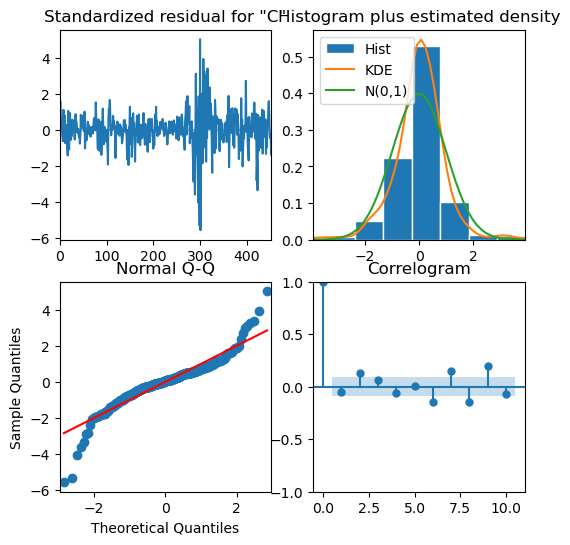

In [219]:
# inspect residuals
modelMA.plot_diagnostics(figsize=(6,6))
plt.show()

Residuals are white noise therefore, good fit

Transform back to prices

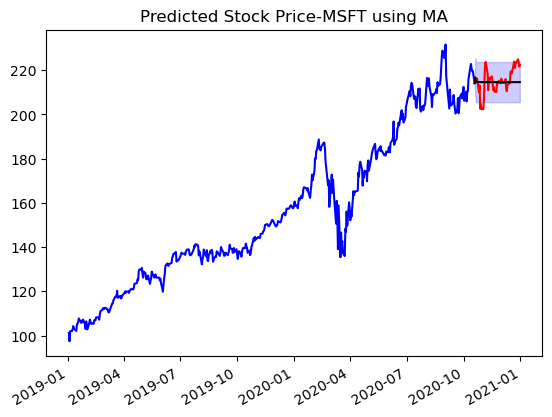

In [220]:
# use 95% confidence interval from above to return price forcasts and confidence intervals
pf=[]
pf.append(price_train[-1])
confd = []
confd.append(price_train[-1])
confu = []
confu.append(price_train[-1])

for ret,dn,up in zip(forecast.predicted_mean.values,conf_int95['lower Close'].values,conf_int95['upper Close'].values):
    new_price = price_train[-1] * (1 + ret)
    confu.append(price_train[-1] * (1 + up))
    confd.append(price_train[-1] * (1 + dn))
    
    pf.append(new_price)

fig,ax = plt.subplots()
ax.plot(price_train.index,price_train.values,color='b',label='Actual')
ax.plot(price_test.index,price_test.values,color='r',label='Test')
ax.plot(price_test.index,pf,color='k',label='Forecast')
ax.fill_between(price_test.index,confd,confu,alpha=0.2,color='b',label='95% CI')
ax.set_title(f'Predicted Stock Price-{ticker} using MA')
plt.gcf().autofmt_xdate()



In [214]:
conf_int80['lower Close'].iloc[i]

-0.025608780730429798

In [141]:
sm.stats.durbin_watson(modelMA.resid.values)


2.021053921541334

Short-term moving average tends to more reactive to daily activity and long MA captures the global trend, But still the model is not able to capture the trends

### Autoregressive Model

Idea is the current value is regressed over its own lag
values in this model. Forcast the current value of time series $X_{t}$:


$X_t = c + \alpha_1 X_{t−1} + \alpha_2 X_{t−2} ... + \alpha_p X_{t−p} + \epsilon_t$



We see a peak in the PCAF of data at p=1

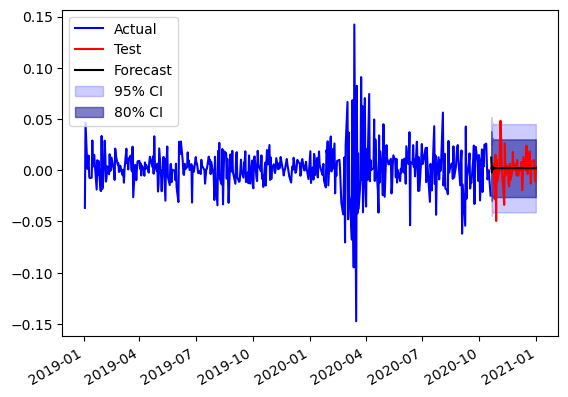

In [221]:
from statsmodels.tsa.arima.model import ARIMA

modelMA = ARIMA(return_train, order=(1, 0, 0)).fit()

forecast = modelMA.get_forecast(steps=len(return_test))

conf_int95 = forecast.conf_int(alpha=0.05)
conf_int80 = forecast.conf_int(alpha=0.2)


fig,ax = plt.subplots()
ax.plot(return_train.index,return_train.values,color='b',label='Actual')
ax.plot(return_test.index,return_test.values,color='r',label='Test')
ax.plot(return_test.index,forecast.predicted_mean,color='k',label='Forecast')
ax.fill_between(return_test.index,conf_int95['lower Close'],conf_int95['upper Close'],alpha=0.2,color='b',label='95% CI')
ax.fill_between(return_test.index,conf_int80['lower Close'],conf_int80['upper Close'],alpha=0.5,color='darkblue',label='80% CI')

ax.legend(loc=2)
plt.gcf().autofmt_xdate()


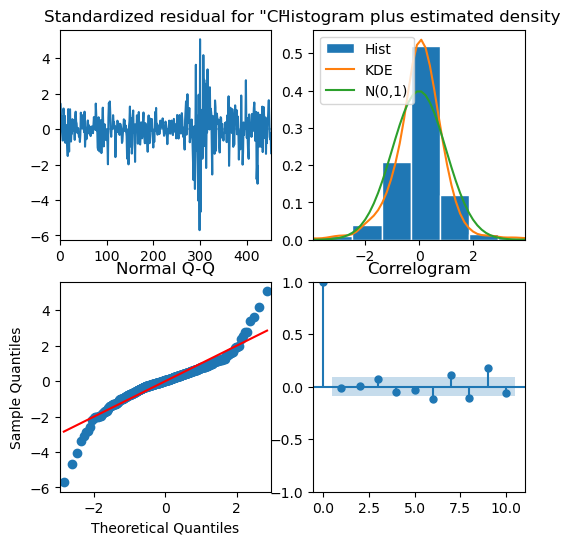

In [222]:
# inspect residuals
modelMA.plot_diagnostics(figsize=(6,6))
plt.show()

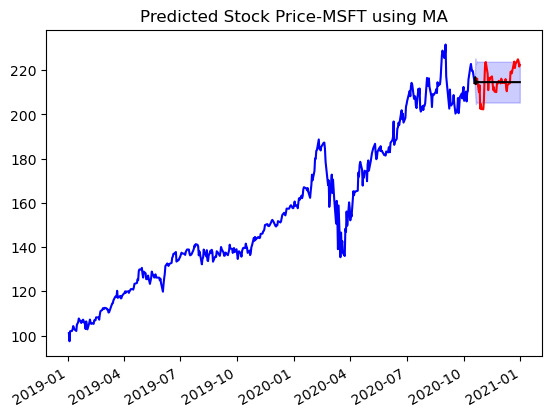

In [223]:
# use 95% confidence interval from above to return price forcasts and confidence intervals
pf=[]
pf.append(price_train[-1])
confd = []
confd.append(price_train[-1])
confu = []
confu.append(price_train[-1])

for ret,dn,up in zip(forecast.predicted_mean.values,conf_int95['lower Close'].values,conf_int95['upper Close'].values):
    new_price = price_train[-1] * (1 + ret)
    confu.append(price_train[-1] * (1 + up))
    confd.append(price_train[-1] * (1 + dn))
    
    pf.append(new_price)

fig,ax = plt.subplots()
ax.plot(price_train.index,price_train.values,color='b',label='Actual')
ax.plot(price_test.index,price_test.values,color='r',label='Test')
ax.plot(price_test.index,pf,color='k',label='Forecast')
ax.fill_between(price_test.index,confd,confu,alpha=0.2,color='b',label='95% CI')
ax.set_title(f'Predicted Stock Price-{ticker} using MA')
plt.gcf().autofmt_xdate()



AR(1) model does a similar job to MA(1) at predicting the stock trend but still is not able to predict it to good affect.
Both models are similar to trivial model with last price forcasting.

### ARIMA Models

ARIMA models are a combination of three key components: AutoRegressive (AR), Integrated (I), and Moving Average (MA). The advantage of intergration parameter is that is non-stationary data is used it can make it stationary by defining the integration parameter. 

Three parameters are to be defined p (dicussed above for AR), q (dicussed for MA) and d (control for level difference). d=1 is makes the model ARMA which is a limiting case of ARIMA (p,1,q) models but is also a good model given by:

$Xt = \alpha_1 dX_{t−1} + \alpha_2 dX_{t−2} ... + \alpha_p dX_{t−p} + \epsilon_t + \beta_1 d\epsilon_{t−1} + \beta_2 d\epsilon_{t−2} ... + \beta_q d\epsilon_{t−q}$

Pros
 - ARIMA allows us to work with raw data without considering if it is
stationary.
 - It performs well with high-frequent data.
It is less sensitive to the fluctuation in the data compared to other models.

Cons
 - ARIMA might fail in capturing seasonality.
 - It work better with a long series and short-term (daily, hourly) data.
 - As no automatic updating occurs in ARIMA, no structural break during the analysis period should be observed.
 - Having no adjustment in the ARIMA process leads to instability.


Choosing the parameters from for the ARIMA model. I choose the range 0-10 for the p and q and 0-3 for d.
Selection of the parameters for the model is made using Akaike Information Criterion (AIC). The parameters resulting in minimum value of AIC are selected. 

$AIC=2k−2ln(L)$

Where:
 - AIC is the Akaike Information Criterion.
 - k is the number of parameters in the model.
 - ln(L) is the natural logarithm of the likelihood of the model.




In [224]:
stat_test = adfuller(returns.dropna())[0:2]
print(f"The test statistic and p-value of ADF test are {stat_test}")
if stat_test[1] < 0.05:
    print("The returns are stationary")
else:
    print("The returns are not stationary")

The test statistic and p-value of ADF test are (-7.212097179922102, 2.2211435488651752e-10)
The returns are stationary


Since returns are stationary so set d=1

In [226]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


model = auto_arima(price_train, start_p=0, start_q=0,
            test='adf',       
            max_p=12, max_q=12,             
            d=1,           
            seasonal=True,  
            start_P=0, 
            D=1, 
            trace=True,
            error_action='ignore',  
            suppress_warnings=True, 
            stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2443.312, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2385.968, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2394.636, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2443.519, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2387.962, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2387.964, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2389.416, Time=0.60 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2388.723, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.156 seconds


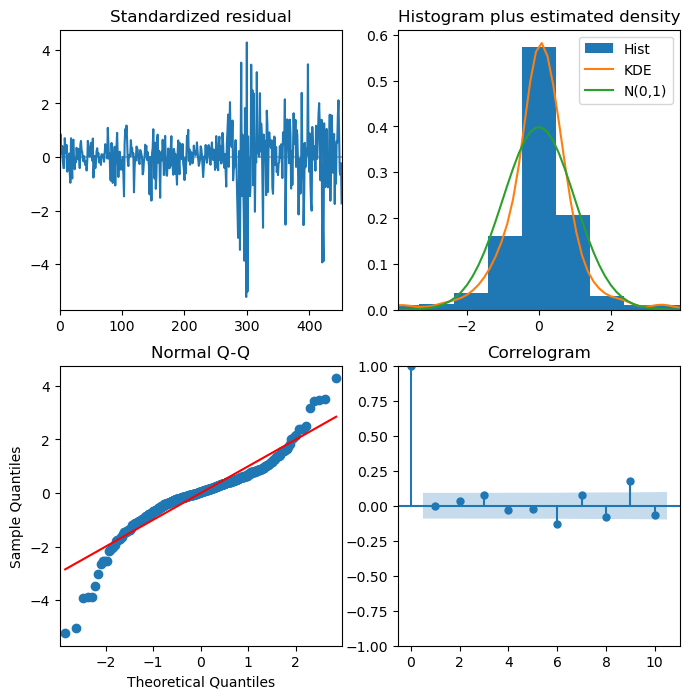

In [227]:
# inspect residuals
model.plot_diagnostics(figsize=(8,8))
plt.show()

In [232]:
y_forec95, conf_int95  = model.predict(len(price_test),return_conf_int=True,alpha=0.05)
y_forec80, conf_int80  = model.predict(len(price_test),return_conf_int=True,alpha=0.2)


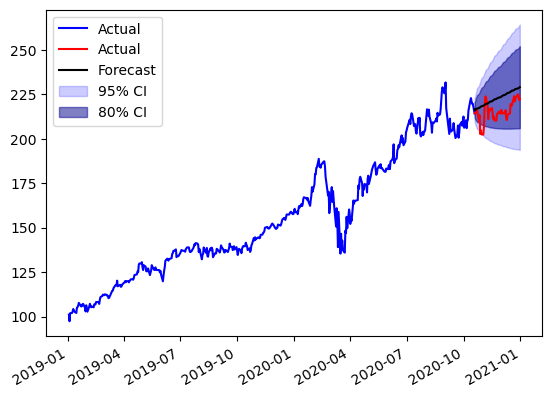

In [233]:

fig,ax = plt.subplots()
ax.plot(price_train.index,price_train.values,color='b',label='Actual')
ax.plot(price_test.index,price_test.values,color='r',label='Actual')
ax.plot(price_test.index,y_forec95,color='k',label='Forecast')
ax.fill_between(price_test.index,conf_int95[:,0],conf_int95[:,1],alpha=0.2,color='b',label='95% CI')
ax.fill_between(price_test.index,conf_int80[:,0],conf_int80[:,1],alpha=0.5,color='darkblue',label='80% CI')

ax.legend(loc=2)
plt.gcf().autofmt_xdate()

The ARIMA model is able to get capture the trend of the price movement and does a better job at predicting prices

## Deep Learning

### Recurrent Neural Network (RNN)

RNNs have three dimensional input, which are:
 - Batch size: the number of observations
 - Time steps: the number of times to feed the model
 - Number of feature: the number of columns of each sample
 



In [1]:

import numpy as np
import pandas as pd
import math
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Dropout, Activation,
Flatten, MaxPooling2D,SimpleRNN)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')



2023-10-16 13:46:41.484582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
n_steps = 13
n_features = 1

# Sequential model to run RNN
model = Sequential()

# Add RNN with 512 neurons with relu activation 
# This is input layer
model.add(SimpleRNN(512, activation='relu',input_shape=(n_steps,n_features),
return_sequences=True))

# Add dropout layer for avoiding overfitting
model.add(Dropout(0.2))

# Add another layer
model.add(Dense(256, activation = 'relu'))

# transforming 3-dimensional matrix into a vector
model.add(Flatten())

# The output layer
model.add(Dense(1, activation='linear'))

# Model compilation with mean squared error as metric and rmsprop optimizer
model.compile(optimizer='rmsprop', loss='mean_squared_error',metrics=
['mse'])


2023-10-16 14:40:32.192118: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)



